/tmp/ipython-input-4-1835978350.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(code, start, end)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-4-1835978350.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  finalValue = data[column][-1]
/tmp/ipython-input-4-1835978350.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  finalValue = data[column][-1]


Final portfolio value: $1356.17
Total Returns: -86.44
Sharpe Ratio: 1.61
Max Drawdown: -0.08
Final portfolio value: $1530.91
Total Returns: -84.69
Sharpe Ratio: 1.93
Max Drawdown: -0.13


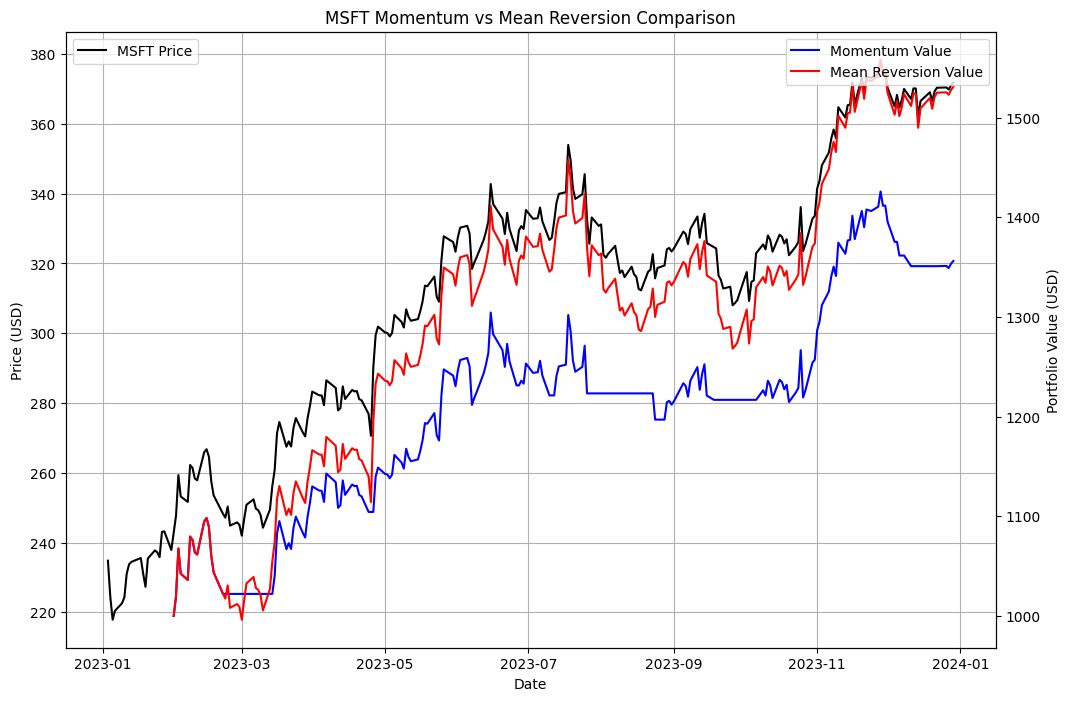

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def loadData(code="MSFT", start="2023-01-01", end="2024-01-01"):
    data = yf.download(code, start, end)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.droplevel(1)

    if 'Close' not in data.columns:
        print("Error: 'Close' column is missing. Check the ticker symbol.")
        print(data.head())
        return None
    data = data[["Close"]]

    return data, code

def signals(data, code):
    data["SMA_20"] = data["Close"].rolling(window=20).mean()
    data["std"] = data["Close"].rolling(window=20).std()

    data["Momentum_Signal"] = 0
    data.loc[data["Close"] > data["std"] * data["SMA_20"], "Momentum_Signal"] = 1   # weak buy
    data.loc[data["Close"] > 2 * data["std"] * data["SMA_20"], "Momentum_Signal"] = 2   # strong buy
    data.loc[data["Close"] < data["std"] * data["SMA_20"], "Momentum_Signal"] = -1  # weak sell
    data.loc[data["Close"] < 2 * data["std"] * data["SMA_20"], "Momentum_Signal"] = -2  # strong sell
    data["Momentum_Confirmed_Signal"] = data["Momentum_Signal"][ # TODO change to accommodate different numbers, not just 0 and 1
        (data["Momentum_Signal"] == data["Momentum_Signal"].shift(1)) & (data["Momentum_Signal"] != 0) # checks signal lasts at least 2 consecutive days, so less noise
    ]
    data["Momentum_Confirmed_Signal"] = data["Momentum_Confirmed_Signal"].fillna(0)

    return data, code

def backtestMomentum(data, code, currentCash=1000, transactionFee=0.001):
    # if greater than sma buy and if less then sell.
    currentStocksBought = 0
    currentValue = currentCash
    peakValue = currentValue
    drawdown = 0

    for date, row in data.iterrows():
        if pd.isna(row["SMA_20"]) or pd.isna(row["Close"]):
            continue

        currentPrice = row["Close"]

        sma20 = row["SMA_20"]
        std = row["std"]

        if drawdown > 0.1: # blocks trades when losing
          continue

        if currentPrice > 2 * std * sma20: # strong buy signal
            if currentCash > 0:
                amountToInvest = currentCash
                currentCash -= amountToInvest * transactionFee
                stocksToBuy = amountToInvest / currentPrice
                currentStocksBought += stocksToBuy
                currentCash = 0

        elif currentPrice > std * sma20: # weak buy
            if currentCash > 0:
                amountToInvest = currentCash / 2
                currentCash -= amountToInvest * transactionFee
                stocksToBuy = amountToInvest / currentPrice
                currentStocksBought += stocksToBuy
                currentCash -= amountToInvest

        elif currentPrice < std * sma20: # weak sell
            if currentStocksBought > 0:
                stocksToSell = currentStocksBought / 2
                proceeds = stocksToSell * currentPrice * (1 - transactionFee)
                currentCash += proceeds
                currentStocksBought -= stocksToSell

        elif currentPrice < 0.5 * std * sma20: # strong sell
            if currentStocksBought > 0:
                proceeds = currentStocksBought * currentPrice * (1 - transactionFee)
                currentCash += proceeds
                currentStocksBought = 0


        assetsValue = currentStocksBought * currentPrice
        currentValue = assetsValue + currentCash
        data.loc[date, "Momentum_Value"] = currentValue # momentum value is like "returns"

        peakValue = max(peakValue, currentValue)
        drawdown = (peakValue - currentValue) / peakValue

    data["Momentum_Value"] = data["Momentum_Value"].astype(float)
    print(f"Final portfolio value: ${currentValue:.2f}")
    metrics(data, "Momentum_Value")

    return data, code

def backtestMeanReversion(data, code, currentCash=1000, transactionFee=0.001):
    # if greater than 1.5std*sma then sell. if less than 1.5std*sma then buy (pairs std ratio?)
    initialCash = currentCash
    currentStocksBought = 0
    currentValue = currentCash
    peakValue = currentValue
    drawdown = 0

    for date, row in data.iterrows():
        if pd.isna(row["SMA_20"]) or pd.isna(row["Close"]):
            continue

        currentPrice = row["Close"]

        sma20 = row["SMA_20"]
        std = row["std"]

        if drawdown > 0.1:
          continue

        if currentPrice < 1.5 * std * sma20: # strong buy
            if currentCash > 0:
                amountToInvest = currentCash
                currentCash -= amountToInvest * transactionFee
                stocksToBuy = amountToInvest / currentPrice
                currentStocksBought += stocksToBuy
                currentCash = 0

        elif currentPrice < 1.2 * std * sma20: # weak buy
            if currentCash > 0:
                amountToInvest = currentCash / 2
                currentCash -= amountToInvest * transactionFee
                stocksToBuy = amountToInvest / currentPrice
                currentStocksBought += stocksToBuy
                currentCash -= amountToInvest

        elif currentPrice > 1.5 * std * sma20: # strong sell
            if currentStocksBought > 0:
                proceeds = currentStocksBought * currentPrice * (1 - transactionFee)
                currentCash += proceeds
                currentStocksBought = 0

        elif currentPrice > 1.2 * std * sma20: # weak sell
            if currentStocksBought > 0:
                stocksToSell = currentStocksBought / 2
                proceeds = stocksToSell * currentPrice * (1 - transactionFee)
                currentCash += proceeds
                currentStocksBought -= stocksToSell


        assetsValue = currentStocksBought * currentPrice
        currentValue = assetsValue + currentCash
        data.loc[date, "MeanReversion_Value"] = currentValue

        peakValue = max(peakValue, currentValue)
        drawdown = (peakValue - currentValue) / peakValue

    data["MeanReversion_Value"] = data["MeanReversion_Value"].astype(float)
    print(f"Final portfolio value: ${currentValue:.2f}")
    metrics(data, "MeanReversion_Value")

    return data, code

def metrics(data, column, initialCash=10000):
    finalValue = data[column][-1]
    totalReturns = (finalValue - initialCash) / 100

    data['dailyReturn'] = data[column].pct_change()
    avgReturn = data['dailyReturn'].mean()
    stdReturn = data['dailyReturn'].std()
    riskFreeRate =  0.0001
    sharpeRatio = ((avgReturn - riskFreeRate) / stdReturn) * np.sqrt(252) # 252 trading days a year

    data['rollingMax'] = data[column].cummax()
    data['drawdown'] = data[column] / data['rollingMax'] - 1
    maxDrawdown = data['drawdown'].min()

    print(f"Total Returns: {totalReturns:.2f}")
    print(f"Sharpe Ratio: {sharpeRatio:.2f}")
    print(f"Max Drawdown: {maxDrawdown:.2f}")

    return totalReturns, maxDrawdown, sharpeRatio

def graph(data, code):#TODO
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # plot first y-axis
    ax1.plot(data.index, data["Close"], label=code + " Price", color="black")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price (USD)")
    ax1.legend(loc="upper left") # legend is the label
    ax1.grid(True)

    # second y axis
    ax2 = ax1.twinx()
    ax2.plot(data.index, data["Momentum_Value"], label="Momentum Value", color="blue")
    ax2.plot(data.index, data["MeanReversion_Value"], label="Mean Reversion Value", color="red")

    ax2.set_ylabel("Portfolio Value (USD)")
    ax2.legend(loc="upper right")


    plt.title(code + " Momentum vs Mean Reversion Comparison")
    plt.show()

data, code = loadData()
data, code = signals(data, code)
data, code = backtestMomentum(data, code)
data, code = backtestMeanReversion(data, code)
graph(data, code)